# Set up

In [1]:
import torch
import torch.nn as nn
import numpy as np
import xarray as xr
from torch.utils.data import TensorDataset, DataLoader
from train import apply_inverse_zca_whitening_4d_torch
from unet import UNet  
from utils import *

setup_random_seeds(42)
device = get_device()

base_path = "gs://leap-persistent/YueWang/SSH/data"
storage_opts = {"token": "cloud", "asynchronous": False}

train = open_zarr(f"{base_path}/train_80_sst.zarr", storage_opts)
test = open_zarr(f"{base_path}/test_80_sst.zarr", storage_opts)
zca = open_zarr(f"{base_path}/zca_80.zarr", storage_opts)

Vt = torch.from_numpy(zca.ubm_Vt.values).float().to(device)
scale = torch.from_numpy(zca.ubm_scale.values).float().to(device)
mean = torch.from_numpy(zca.ubm_mean.values).float().to(device)

# Model 1: ZCA NLL Loss with SSH+SST input

# Prepare training data for normalization statistics (SSH+SST)
x_train_ssh = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_sst = torch.from_numpy(train.sst.values).float().unsqueeze(1).to(device)
x_train = torch.cat([x_train_ssh, x_train_sst], dim=1)
x_train_normalized, min_vals_sst, max_vals_sst = min_max_normalize(x_train)

# Prepare test data (SSH+SST) 
x_test_ssh_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_sst_original = torch.from_numpy(test.sst.values).float().unsqueeze(1).to(device)
x_test_original = torch.cat([x_test_ssh_original, x_test_sst_original], dim=1)

# Normalize test data for model input
x_test_normalized, _, _ = min_max_normalize(x_test_original, min_vals_sst, max_vals_sst)

# Prepare test targets
y_test_physical = torch.from_numpy(test.ubm.values).float().unsqueeze(1).to(device)
y_test_zca = torch.from_numpy(test.zca_ubm.values).float().unsqueeze(1).to(device)
y_test = torch.cat([y_test_physical, y_test_zca], dim=1)

# Create test dataset and loader
test_dataset_sst = TensorDataset(x_test_normalized, y_test)
test_loader_sst = DataLoader(test_dataset_sst, batch_size=32, shuffle=False)

# Load model
model_sst_ssh = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_sst_ssh.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/sst_ssh.pth', map_location=device)
model_sst_ssh.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_sst_ssh.eval()
results_sst_ssh = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

sample_indices = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_sst):
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices.extend(current_batch_indices)
        
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)

        outputs = model_sst_ssh(batch_x)
        
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=30)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_sst_ssh['ssh'].append(ssh_batch_original.cpu().numpy())
        results_sst_ssh['sst'].append(sst_batch_original.cpu().numpy())
        results_sst_ssh['ubm_true'].append(ubm_true.cpu().numpy())
        results_sst_ssh['bm_true'].append(bm_true.cpu().numpy())
        results_sst_ssh['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_sst_ssh['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_sst_ssh['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_sst_ssh['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

for key in results_sst_ssh:
    results_sst_ssh[key] = np.concatenate(results_sst_ssh[key], axis=0)

print("Model 1 evaluation complete!")

# Model 2: SSH input only

# Prepare training data for normalization statistics (SSH only)
x_train_ssh_only = torch.from_numpy(train.ssh.values).float().unsqueeze(1).to(device)
x_train_normalized_ssh, min_vals_ssh, max_vals_ssh = min_max_normalize(x_train_ssh_only)

# Prepare test data (SSH only)
x_test_ssh_only_original = torch.from_numpy(test.ssh.values).float().unsqueeze(1).to(device)
x_test_normalized_ssh, _, _ = min_max_normalize(x_test_ssh_only_original, min_vals_ssh, max_vals_ssh)

# Create test dataset and loader
test_dataset_ssh = TensorDataset(x_test_normalized_ssh, y_test)
test_loader_ssh = DataLoader(test_dataset_ssh, batch_size=32, shuffle=False)

# Load model
model_ssh_only = UNet(in_channels=1, out_channels=2, initial_features=32, depth=4)
model_ssh_only.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/ssh_input_only.pth', map_location=device)
model_ssh_only.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_ssh_only.eval()
results_ssh_only = {
    'ssh': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': [],
    'ubm_pred_ensembles': [], 'bm_pred_ensembles': []
}

sample_indices_ssh = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_ssh):
        
        batch_start = i * test_loader_ssh.batch_size
        batch_end = min(batch_start + test_loader_ssh.batch_size, len(test_dataset_ssh))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices_ssh.extend(current_batch_indices)
            
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)
        
        outputs = model_ssh_only(batch_x)
        
        ssh_batch_original = x_test_ssh_only_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # Predicted mean in physical space
        mu_zca = outputs[:, 0, ...]
        log_sigma_zca = outputs[:, 1, ...]
        mu_zca_expanded = mu_zca.unsqueeze(1)
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        # BM prediction using original SSH scale
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Generate ensemble samples
        zca_samples = generate_gaussian_samples(mu_zca, log_sigma_zca, n_samples=30)
        B, n_samples, H, W = zca_samples.shape
        zca_samples_flat = zca_samples.reshape(B * n_samples, 1, H, W)
        ubm_samples_flat = apply_inverse_zca_whitening_4d_torch(zca_samples_flat, Vt, scale, mean)
        ubm_samples = ubm_samples_flat.reshape(B, n_samples, 1, H, W)
        
        # Use original SSH for ensemble BM calculation
        ssh_expanded = ssh_batch_original.unsqueeze(1).expand(-1, n_samples, -1, -1, -1)
        bm_samples = ssh_expanded - ubm_samples
        
        # Store results 
        results_ssh_only['ssh'].append(ssh_batch_original.cpu().numpy())
        results_ssh_only['ubm_true'].append(ubm_true.cpu().numpy())
        results_ssh_only['bm_true'].append(bm_true.cpu().numpy())
        results_ssh_only['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_ssh_only['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())
        results_ssh_only['ubm_pred_ensembles'].append(ubm_samples.cpu().numpy())
        results_ssh_only['bm_pred_ensembles'].append(bm_samples.cpu().numpy())

for key in results_ssh_only:
    results_ssh_only[key] = np.concatenate(results_ssh_only[key], axis=0)

print("Model 2 evaluation complete!")

# Model 3: MSE loss only
model_mse_only = UNet(in_channels=2, out_channels=2, initial_features=32, depth=4)
model_mse_only.to(device)

checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/mse_loss_only.pth', map_location=device)
model_mse_only.load_state_dict(checkpoint['model_state_dict'])

# Evaluate model
model_mse_only.eval()
results_mse_only = {
    'ssh': [], 'sst': [], 'ubm_true': [], 'bm_true': [],
    'ubm_pred_mu': [], 'bm_pred_mu': []
}

sample_indices_mse = []

with torch.no_grad():
    for i, (batch_x, batch_y) in enumerate(test_loader_sst):  
        
        batch_start = i * test_loader_sst.batch_size
        batch_end = min(batch_start + test_loader_sst.batch_size, len(test_dataset_sst))
        current_batch_indices = list(range(batch_start, batch_end))
        sample_indices_mse.extend(current_batch_indices)
            
        batch_x = batch_x.to(device)
        batch_y_physical = batch_y[:, 0:1, ...].to(device)
        
        outputs = model_mse_only(batch_x)
        
        # Use original scale SSH and SST for BM calculation
        ssh_batch_original = x_test_ssh_original[current_batch_indices]
        sst_batch_original = x_test_sst_original[current_batch_indices]
        
        ubm_true = batch_y_physical
        bm_true = ssh_batch_original - ubm_true
        
        # For MSE model, only use mean prediction (no sampling)
        mu_zca_expanded = outputs[:, 0:1, ...]  # Use first channel as mean
        ubm_pred_mu = apply_inverse_zca_whitening_4d_torch(mu_zca_expanded, Vt, scale, mean)
        # BM prediction using original SSH scale
        bm_pred_mu = ssh_batch_original - ubm_pred_mu
        
        # Store results
        results_mse_only['ssh'].append(ssh_batch_original.cpu().numpy())
        results_mse_only['sst'].append(sst_batch_original.cpu().numpy())
        results_mse_only['ubm_true'].append(ubm_true.cpu().numpy())
        results_mse_only['bm_true'].append(bm_true.cpu().numpy())
        results_mse_only['ubm_pred_mu'].append(ubm_pred_mu.cpu().numpy())
        results_mse_only['bm_pred_mu'].append(bm_pred_mu.cpu().numpy())

for key in results_mse_only:
    results_mse_only[key] = np.concatenate(results_mse_only[key], axis=0)

print("Model 3 evaluation complete!")

# Create xarray datasets and save results
models_results = [
    ('sst_ssh', results_sst_ssh, True, True),
    ('ssh_only', results_ssh_only, True, False), 
    ('mse_only', results_mse_only, False, True)
]

# Store all datasets
eval_datasets = {}


def create_evaluation_dataset(results, model_name, has_ensembles=True, has_sst=True):
    """Create xarray dataset from evaluation results"""
    n_samples = results['ssh'].shape[0]
    H, W = results['ssh'].shape[2], results['ssh'].shape[3]
    
    # Create base coordinate arrays
    coords = {
        'sample': range(n_samples),
        'i': range(H),
        'j': range(W)
    }
    
    # Add stochastic_sample coordinate if we have ensembles
    if has_ensembles and 'ubm_pred_ensembles' in results:
        coords['stochastic_sample'] = range(30)
    
    # Create data variables
    data_vars = {
        'ssh': (['sample', 'i', 'j'], results['ssh'].squeeze(1)),
        'ubm_truth': (['sample', 'i', 'j'], results['ubm_true'].squeeze(1)),
        'bm_truth': (['sample', 'i', 'j'], results['bm_true'].squeeze(1)),
        'ubm_pred_mean': (['sample', 'i', 'j'], results['ubm_pred_mu'].squeeze(1)),
        'bm_pred_mean': (['sample', 'i', 'j'], results['bm_pred_mu'].squeeze(1))
    }
    
    # Add SST if available
    if has_sst and 'sst' in results:
        data_vars['sst'] = (['sample', 'i', 'j'], results['sst'].squeeze(1))
    
    # Add ensemble results if available
    if has_ensembles and 'ubm_pred_ensembles' in results:
        print(f"Adding ensemble data with shape: {results['ubm_pred_ensembles'].shape}")
        # Fix: squeeze the extra channel dimension (index 2)
        data_vars['ubm_pred_samples'] = (['sample', 'stochastic_sample', 'i', 'j'], 
                                        results['ubm_pred_ensembles'].squeeze(2))
        data_vars['bm_pred_samples'] = (['sample', 'stochastic_sample', 'i', 'j'], 
                                       results['bm_pred_ensembles'].squeeze(2))
    
    return xr.Dataset(data_vars, coords=coords)
    
for model_name, results, has_ensembles, has_sst in models_results:
    print(f"Creating dataset for {model_name}...")
    
    eval_dataset = create_evaluation_dataset(results, model_name, has_ensembles, has_sst)
    
    # Store the dataset
    eval_datasets[model_name] = eval_dataset


Using device: cpu


/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7fbb752f1670>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7fbb752f1670>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/srv/conda/envs/notebook/lib/python3.12/site-packages/zarr/storage/_fsspec.py:256: UserWarning: fs (<gcsfs.core.GCSFileSystem object at 0x7fbb752f1670>) was not created with `asynchronous=True`, this may lead to surprising behavior
  return cls(fs=fs, path=path, read_only=read_only, allowed_exceptions=allowed_exceptions)
/tmp/ipykernel_467/818614285.py

Model 1 evaluation complete!


/tmp/ipykernel_467/818614285.py:137: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/ssh_input_only.pth', map_locatio

Model 2 evaluation complete!


/tmp/ipykernel_467/818614285.py:205: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load('/home/jovyan/GRL_ssh/checkpoints/mse_loss_only.pth', map_location

Model 3 evaluation complete!
Creating dataset for sst_ssh...
Adding ensemble data with shape: (3645, 30, 1, 80, 80)
Creating dataset for ssh_only...
Adding ensemble data with shape: (3645, 30, 1, 80, 80)
Creating dataset for mse_only...


# Figure 1

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.ticker as ticker
import cmocean.cm as cmo
from sklearn.metrics import r2_score

# Constants 
g = 9.81       
dx = 1500.0   # m   (1.5 km grid)
dy = 1500.0   # m
f_cor = -8.6e-5  #  (Agulhas region)

def flatten_clean(da, clean_idx):
    return da.isel(sample=clean_idx).stack(pixels=("i", "j")).values

def calculate_geostrophic_speed(field):
    """Calculate the geostrophic speed from a 2D field of sea surface height."""
    dη_dy = np.gradient(field, dy, axis=0, edge_order=2)
    dη_dx = np.gradient(field, dx, axis=1, edge_order=2)
    u_g = -g / f_cor * dη_dy
    v_g = g / f_cor * dη_dx
    speed = np.sqrt(u_g**2 + v_g**2)
    return speed

def find_extreme_samples(model_pred, truth, clean_idx, model_name="Selected Model"):
    """Find sample indices with maximum, median, and minimum R² values"""
    r2_vals = []
    
    for t, p in zip(flatten_clean(truth, clean_idx), flatten_clean(model_pred, clean_idx)):
        m = np.isfinite(t) & np.isfinite(p)
        if m.sum() < 2:
            r2_vals.append(np.nan)
        else:
            r2_vals.append(r2_score(t[m], p[m]))
    
    r2_vals = np.array(r2_vals)
    non_nan_indices = np.where(~np.isnan(r2_vals))[0]
    valid_r2 = r2_vals[non_nan_indices]
    
    max_local_idx = np.argmax(valid_r2)
    min_local_idx = np.argmin(valid_r2)
    sorted_indices = np.argsort(valid_r2)
    median_local_idx = sorted_indices[len(sorted_indices) // 2]
    
    max_sample_idx = clean_idx[non_nan_indices[max_local_idx]]
    min_sample_idx = clean_idx[non_nan_indices[min_local_idx]]
    median_sample_idx = clean_idx[non_nan_indices[median_local_idx]]
    
    
    return {
        "max": {"sample_idx": int(max_sample_idx), "r2": float(valid_r2[max_local_idx])},
        "median": {"sample_idx": int(median_sample_idx), "r2": float(valid_r2[median_local_idx])},
        "min": {"sample_idx": int(min_sample_idx), "r2": float(valid_r2[min_local_idx])}
    }

def format_ax(ax, title=None, row_label=None):
    """Format axis for 4x4 comparison plots"""
    size = 80
    title_fontsize = 32
    title_pad = 15
    
    tick_positions = np.linspace(0, size-1, 9)
    tick_positions = np.round(tick_positions).astype(int)
    
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.tick_params(axis='both', which='major', length=6, width=1.5, color='black')
    
    if title is not None:
        ax.set_title(title, fontsize=title_fontsize, pad=title_pad, fontweight='bold')
    
    if row_label:
        ax.text(-0.15, 0.5, row_label, transform=ax.transAxes, 
                fontsize=title_fontsize, ha='center', va='center', rotation=90,
                fontweight='bold')

def format_ax_ssh(ax, title):
    """Format axis for SSH plots"""
    size = 80
    title_fontsize = 28
    title_pad = 15

    # Calculate tick positions in pixel units - 8 sections of 10 pixels each
    tick_positions = np.linspace(0, size-1, 9)  # 9 points to create 8 sections
    tick_positions = np.round(tick_positions).astype(int)  # Round to integers
    
    # Calculate km values (each pixel = 1.5km)
    km_ticks = tick_positions * 1.5
    
    # Set ticks
    ax.set_xticks(tick_positions)
    ax.set_yticks(tick_positions)
    
    # Add km labels every other tick (show labels at positions 0, 2, 4, 6, 8)
    x_labels = []
    y_labels = []
    for i, km in enumerate(km_ticks):
        if i % 2 == 0:  # Every even index (0, 2, 4, 6, 8)
            x_labels.append(f'{km:.0f}')
            y_labels.append(f'{km:.0f}')
        else:
            x_labels.append('')  # Empty string for odd indices
            y_labels.append('')  # Empty string for odd indices
    
    ax.set_xticklabels(x_labels)
    ax.set_yticklabels(y_labels)

    # Make ticks and labels more visible
    ax.tick_params(axis='both', which='major', length=7, width=1.5, labelsize=26)
    
    # Set title
    ax.set_title(title, fontsize=title_fontsize, pad=title_pad, loc='center', fontweight='bold')
    
    # Add km labels to axes
    ax.set_xlabel('Distance (km)', fontsize=28)



# Clean sample mask (no NaNs in truth UBM)
clean_mask = ~test.ubm.isnull().any(dim=("i", "j")).values
clean_idx = np.where(clean_mask)[0]

# Find extreme samples for each model using their UBM predictions
extreme_samples = {}

# For ZCA+SST model
extreme_samples['sst_ssh'] = find_extreme_samples(
    eval_datasets['sst_ssh'].ubm_pred_mean, 
    test.ubm, clean_idx, 
    model_name="ZCA+SST"
)

# For SSH-only model  
extreme_samples['ssh_only'] = find_extreme_samples(
    eval_datasets['ssh_only'].ubm_pred_mean, 
    test.ubm, clean_idx, 
    model_name="SSH-only"
)

# For MSE-only model
extreme_samples['mse_only'] = find_extreme_samples(
    eval_datasets['mse_only'].ubm_pred_mean, 
    test.ubm, clean_idx, 
    model_name="MSE-only"
)

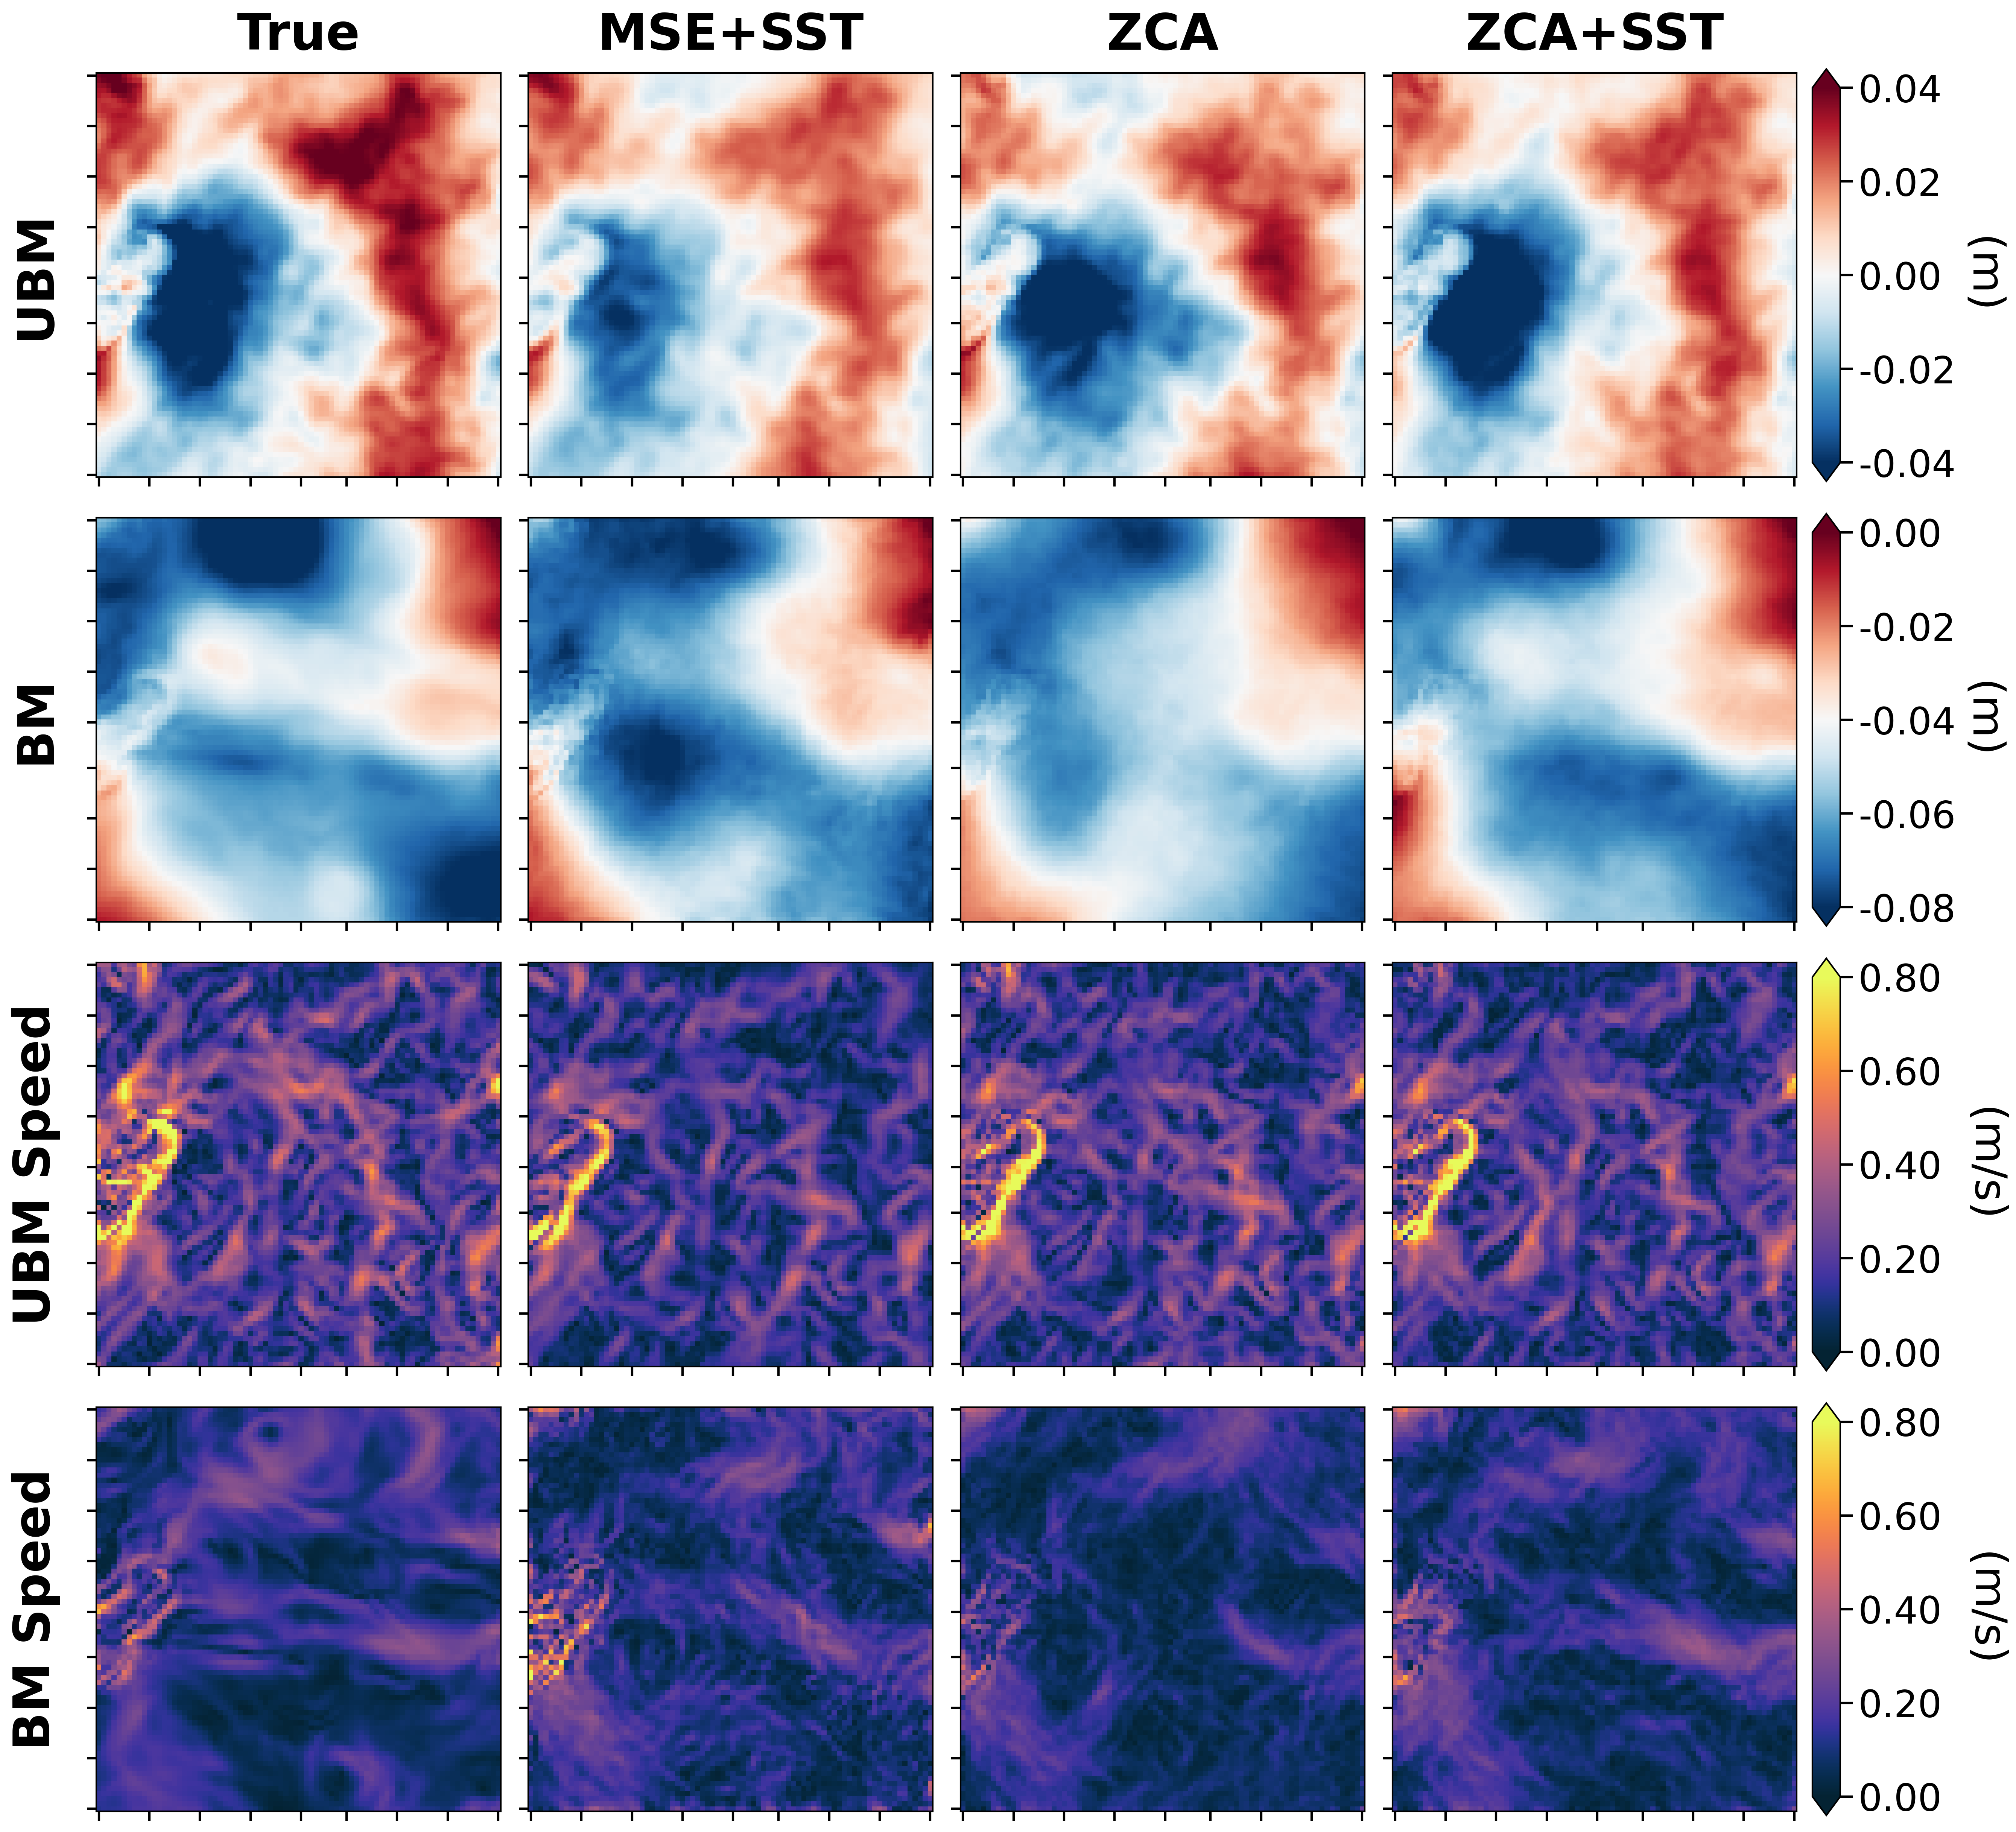

Best sample comparison saved (Sample #3041, R²=0.9127)


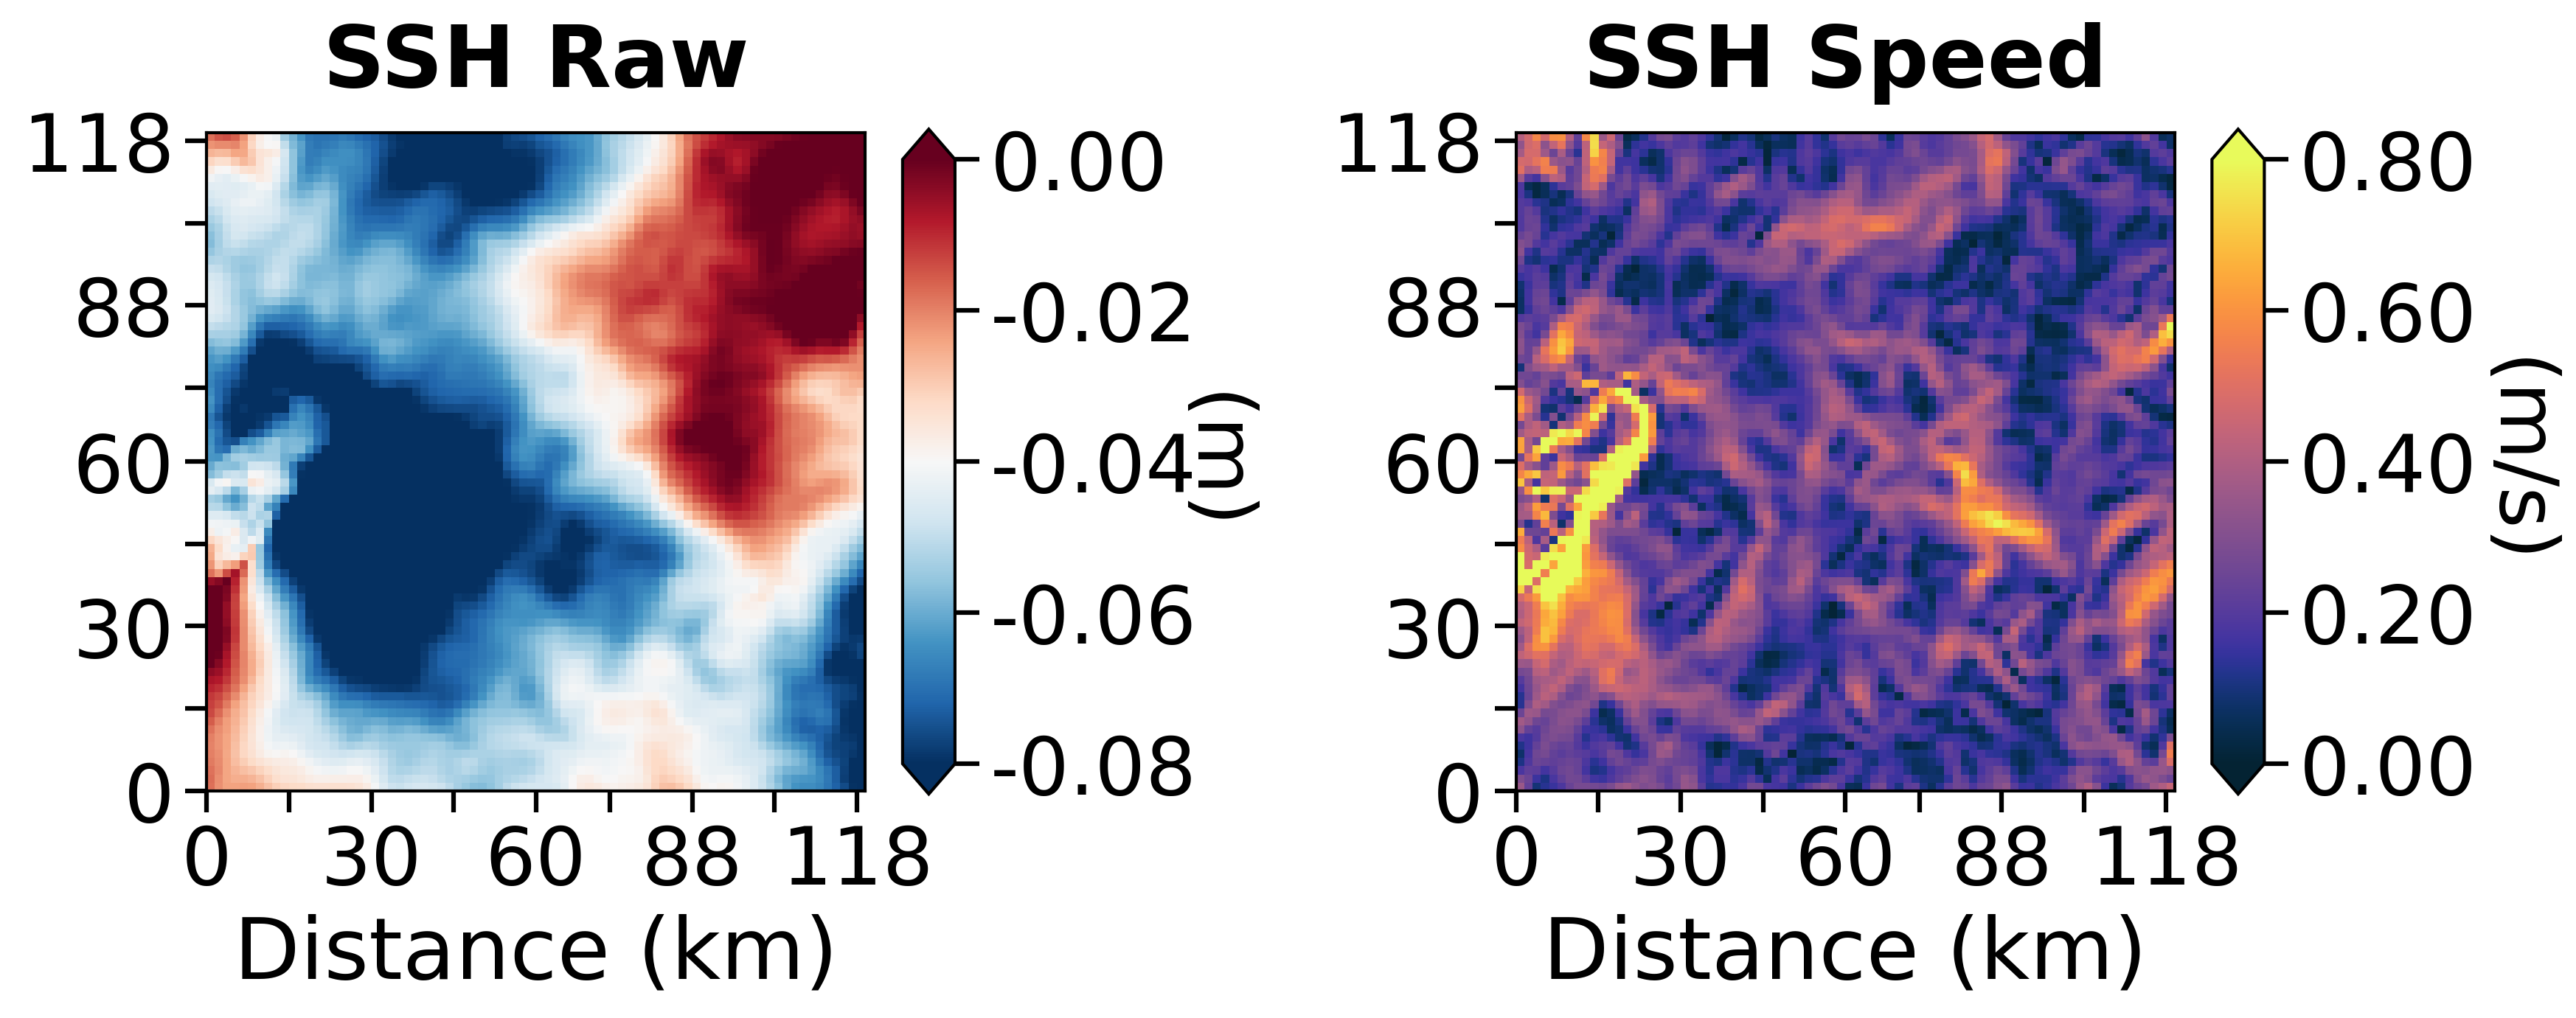

Best SSH visualization saved (Sample #3041, R²=0.9127)


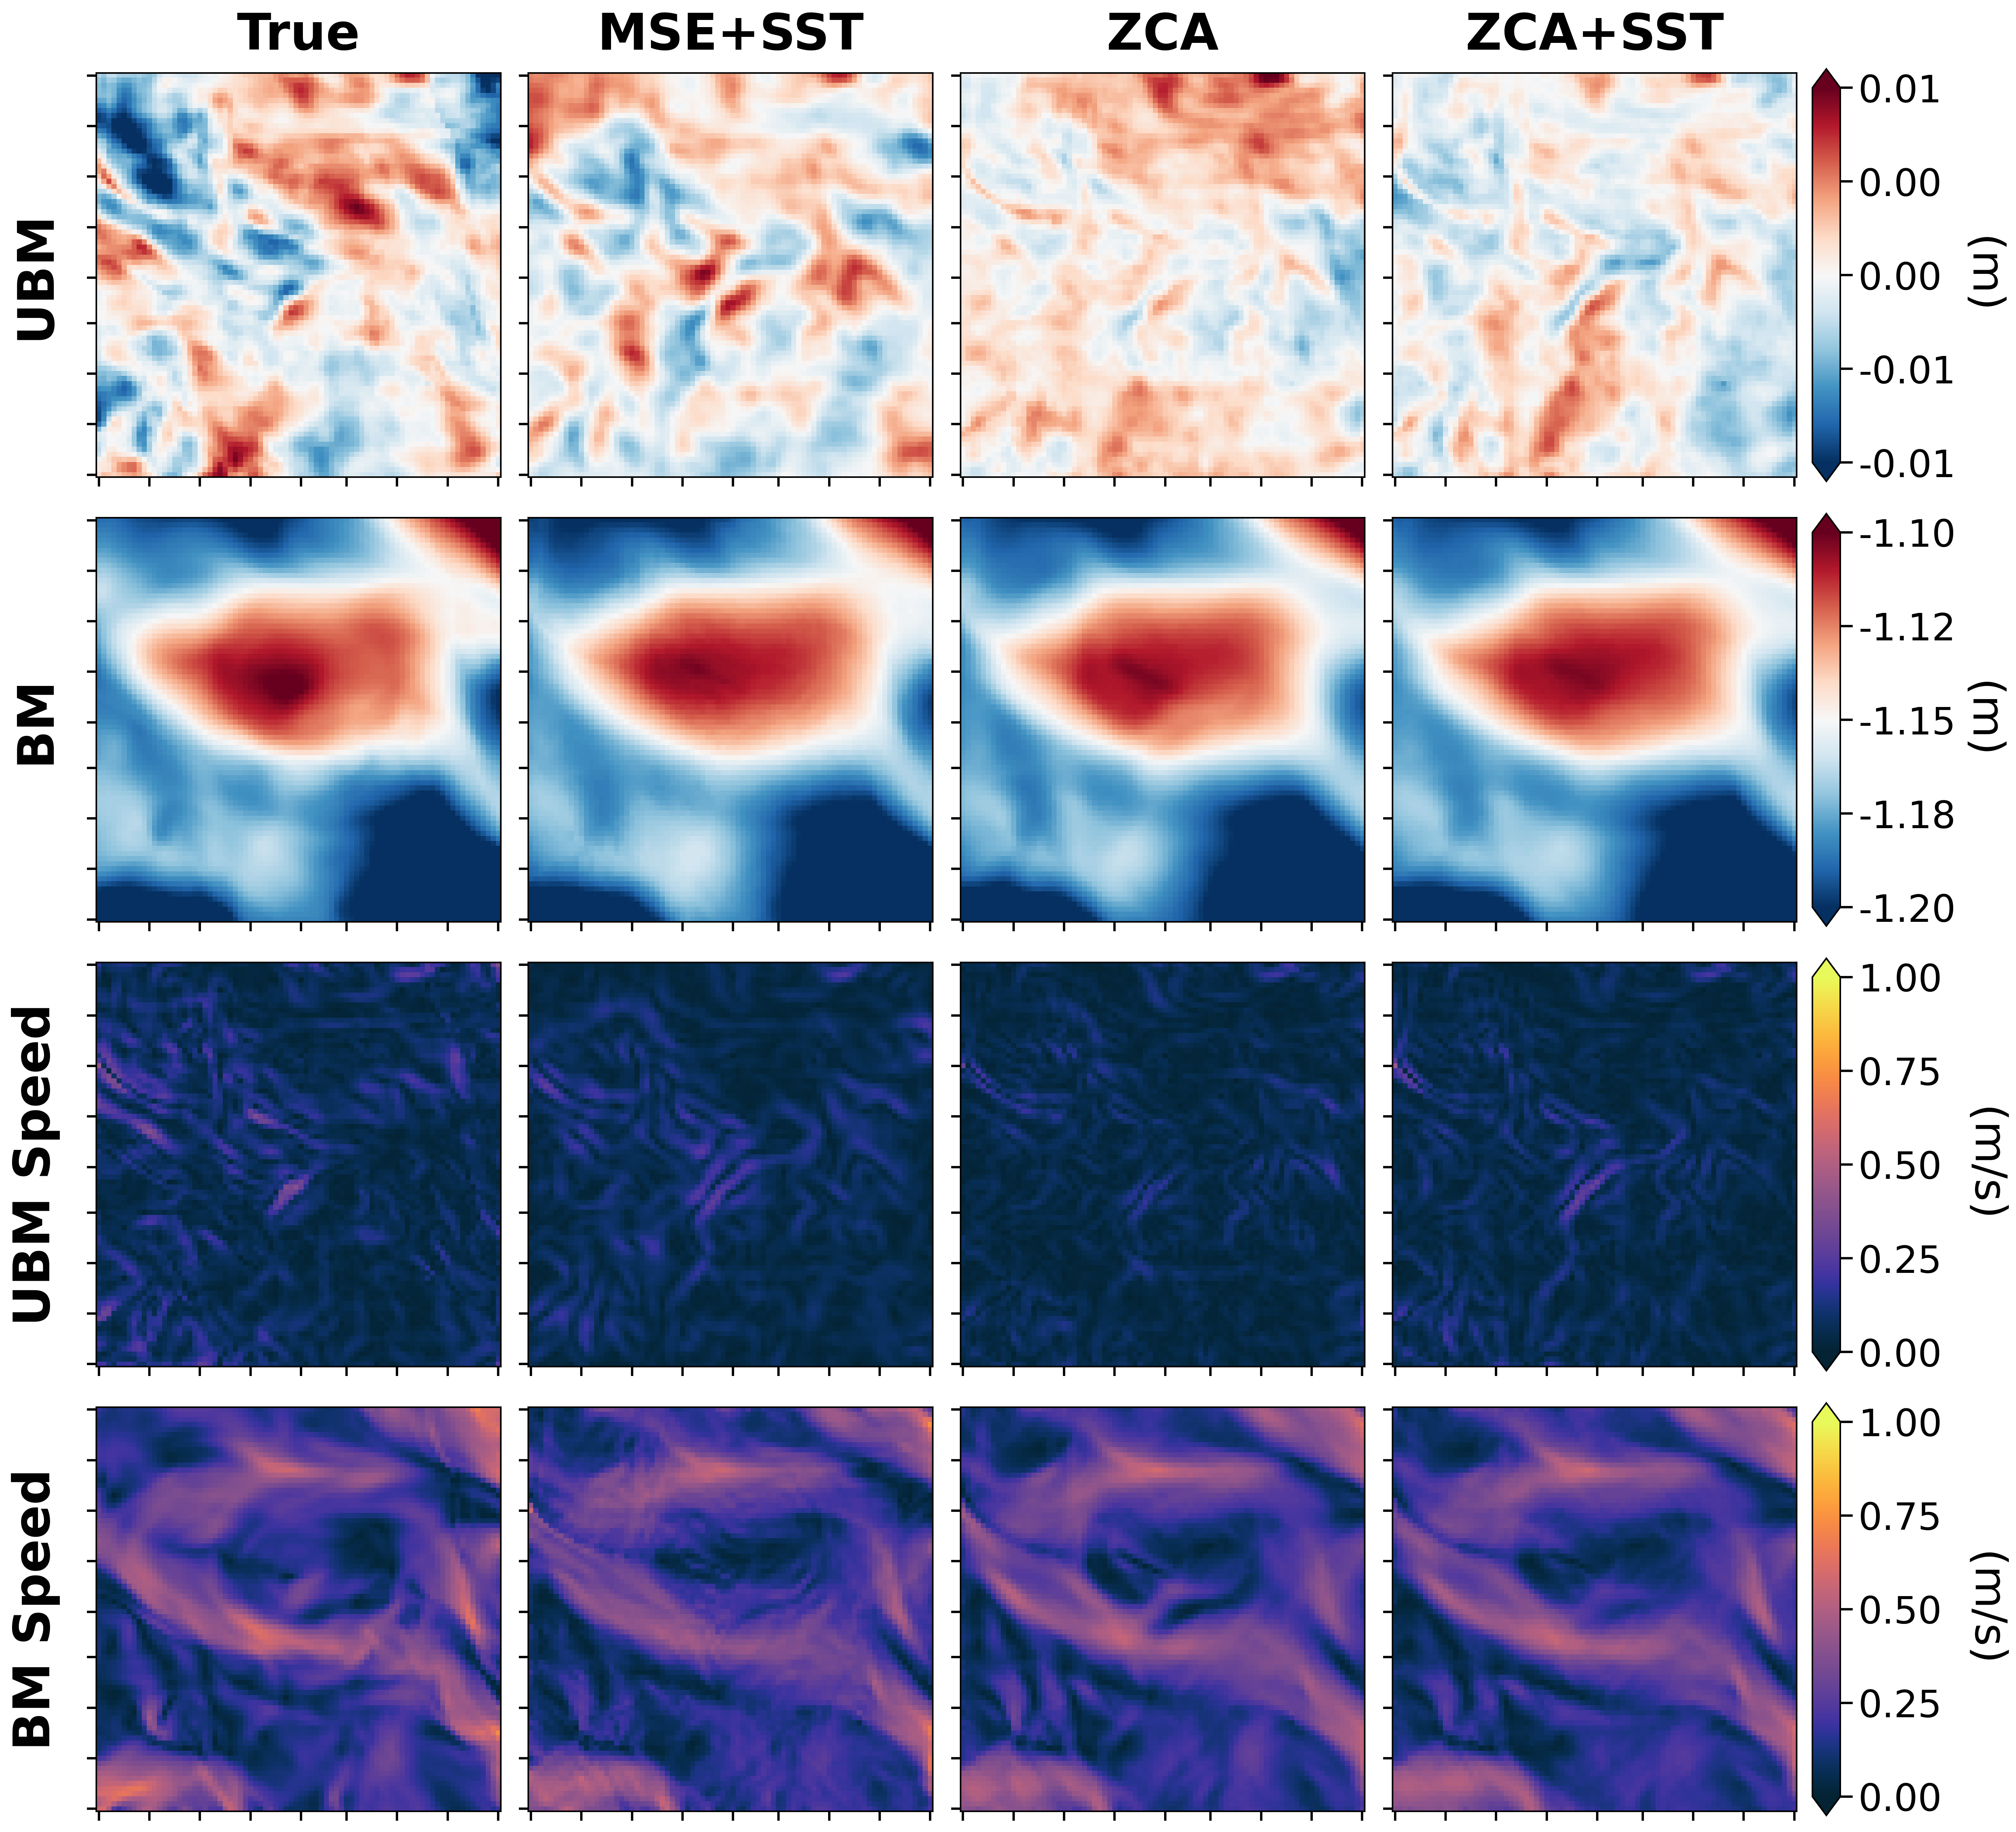

Median sample comparison saved (Sample #519, R²=0.0866)


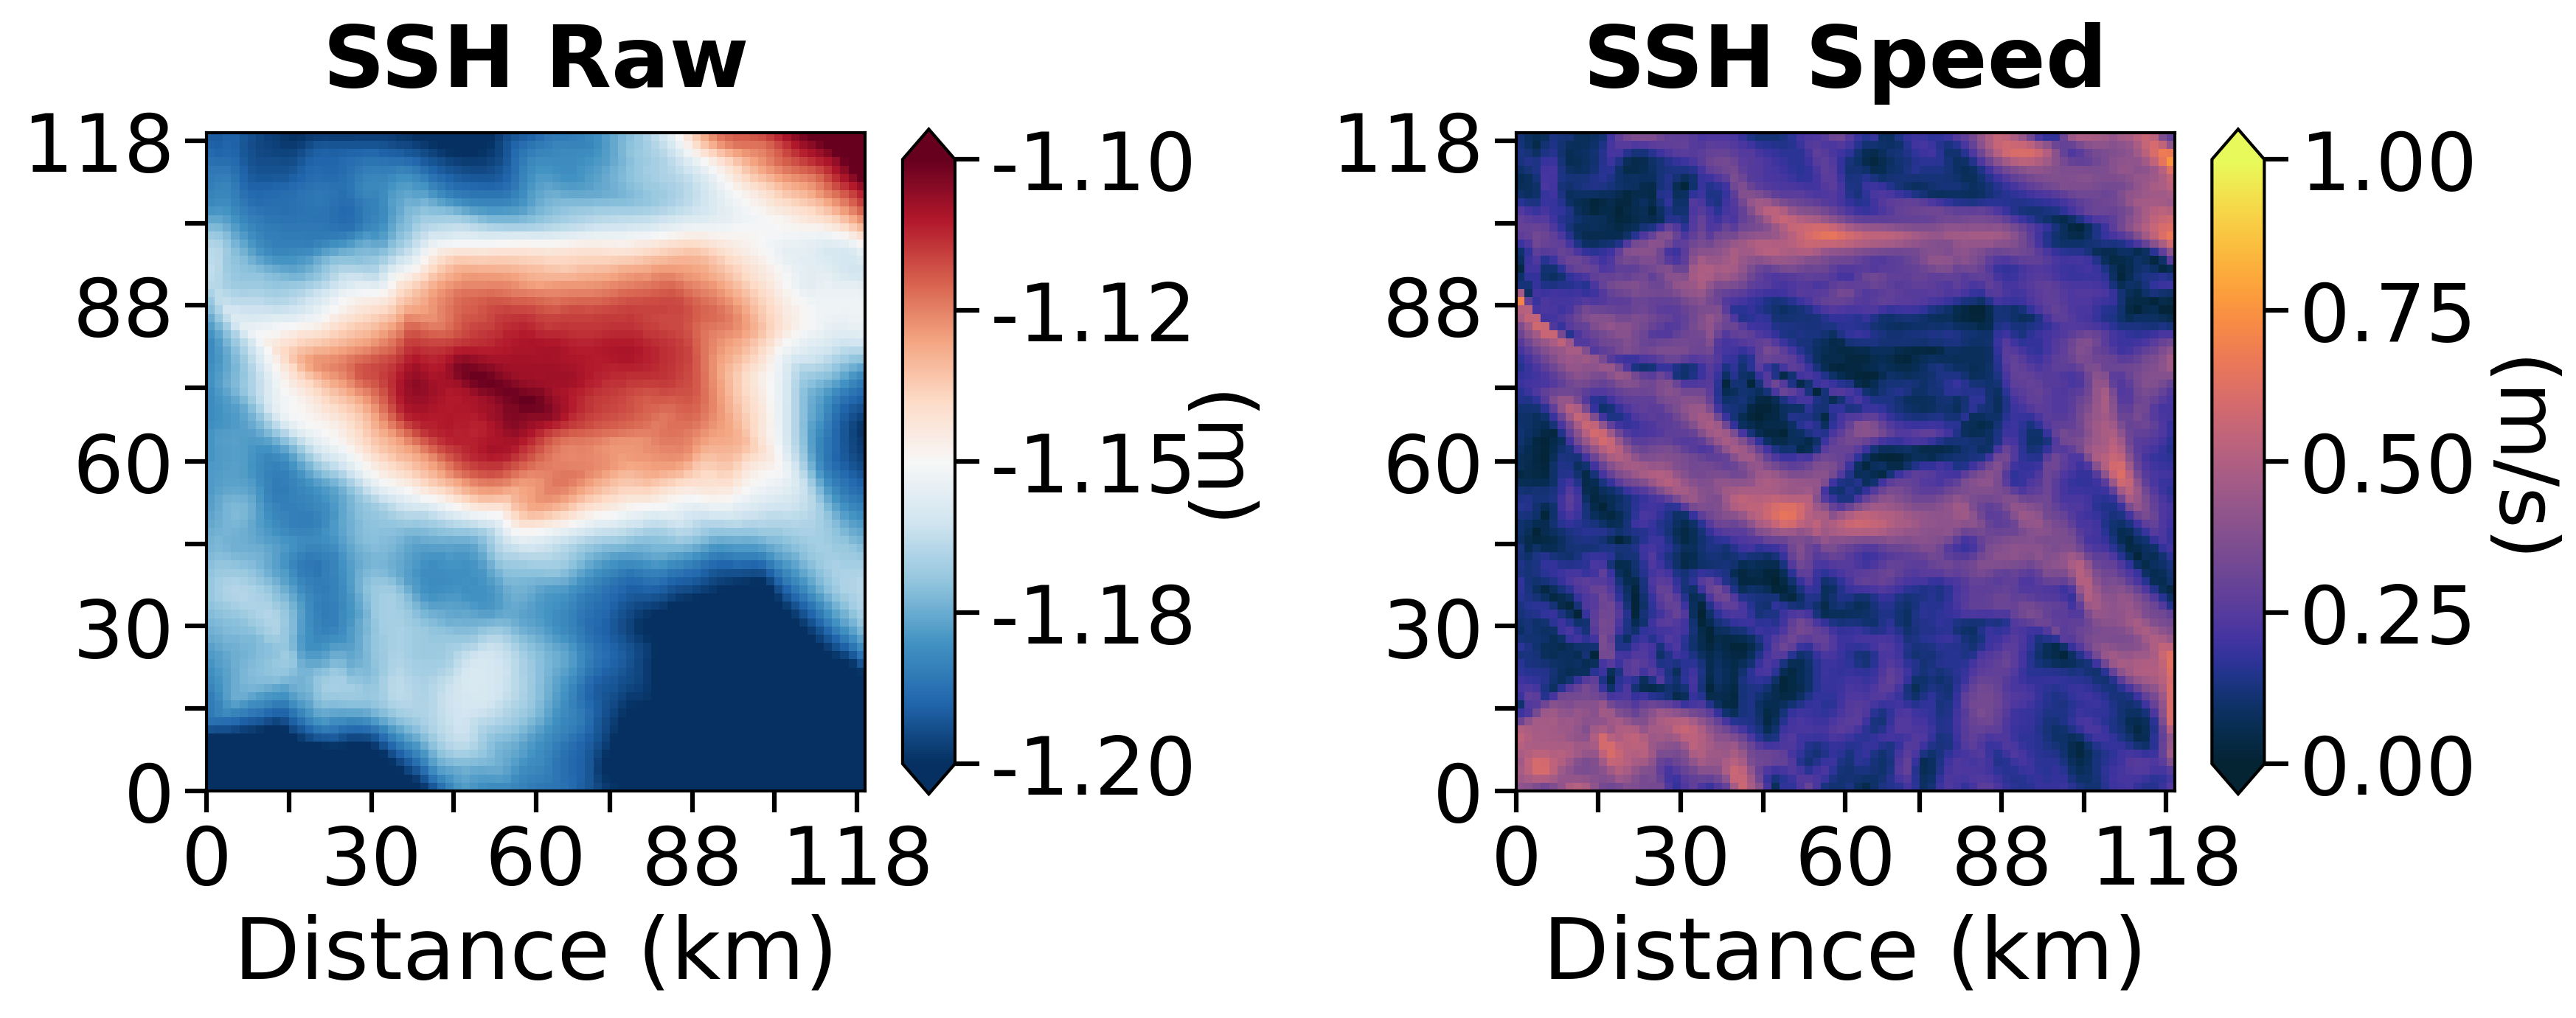

Median SSH visualization saved (Sample #519, R²=0.0866)


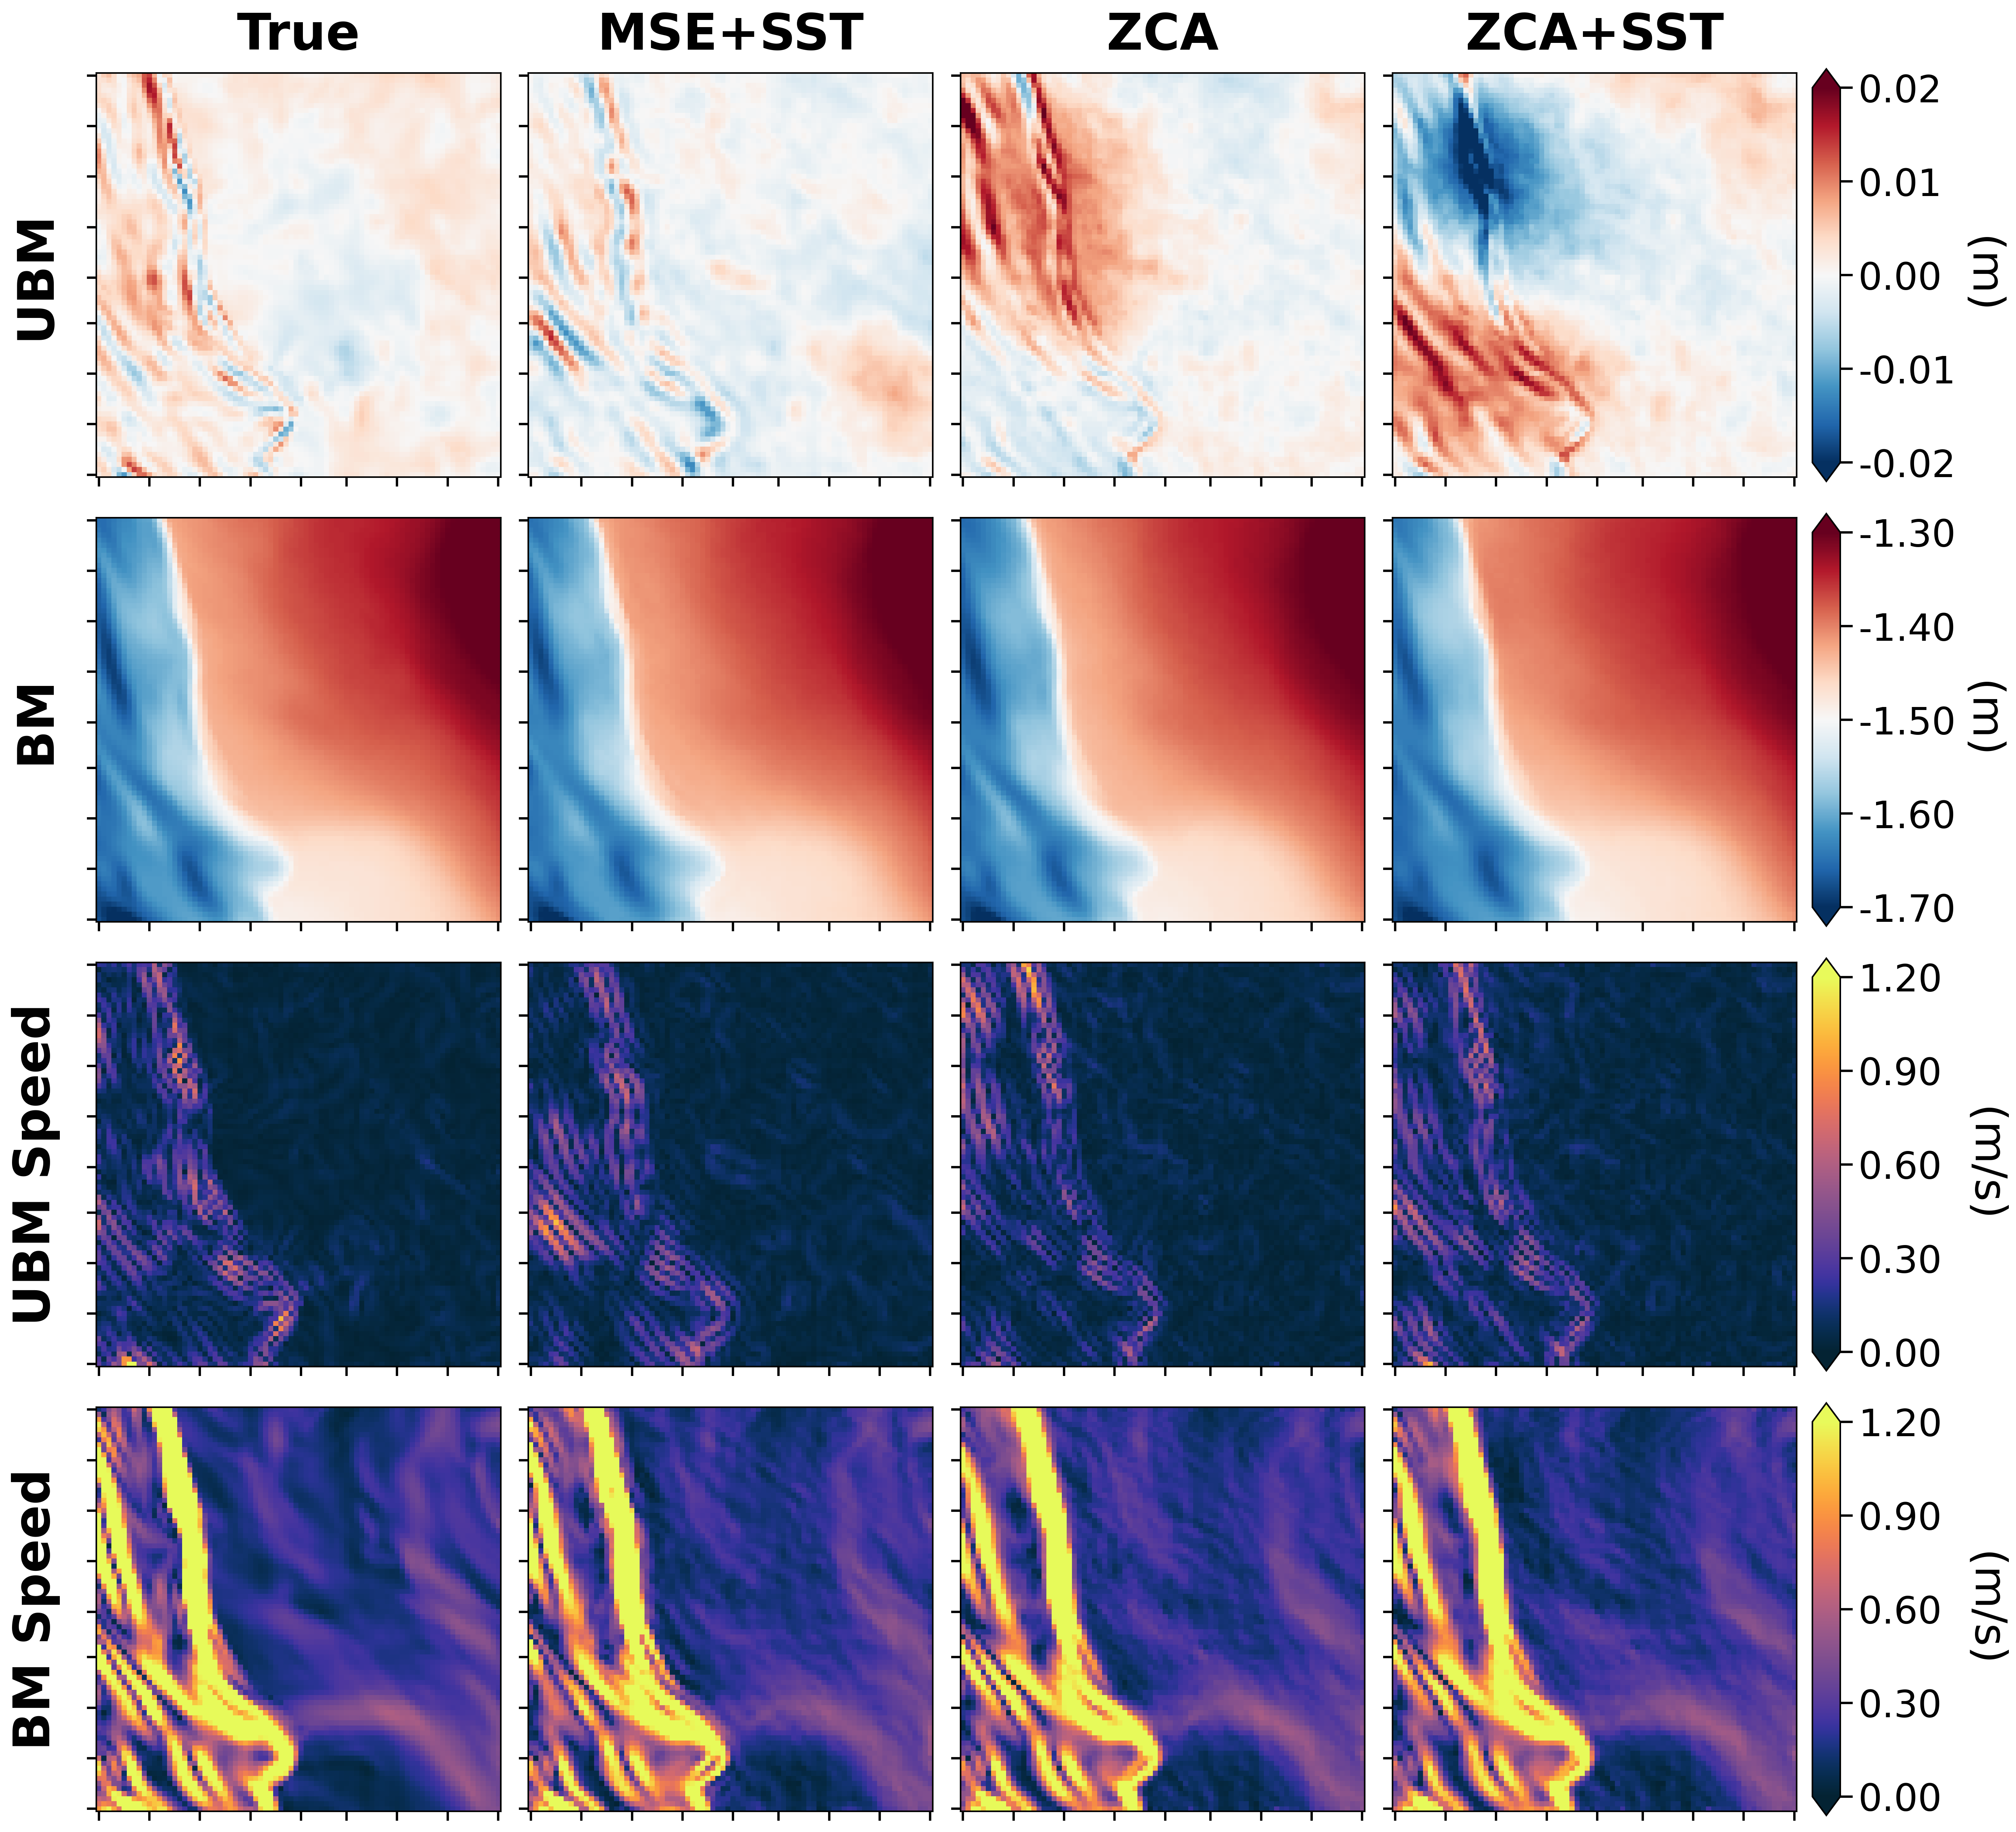

Worst sample comparison saved (Sample #3323, R²=-6.2663)


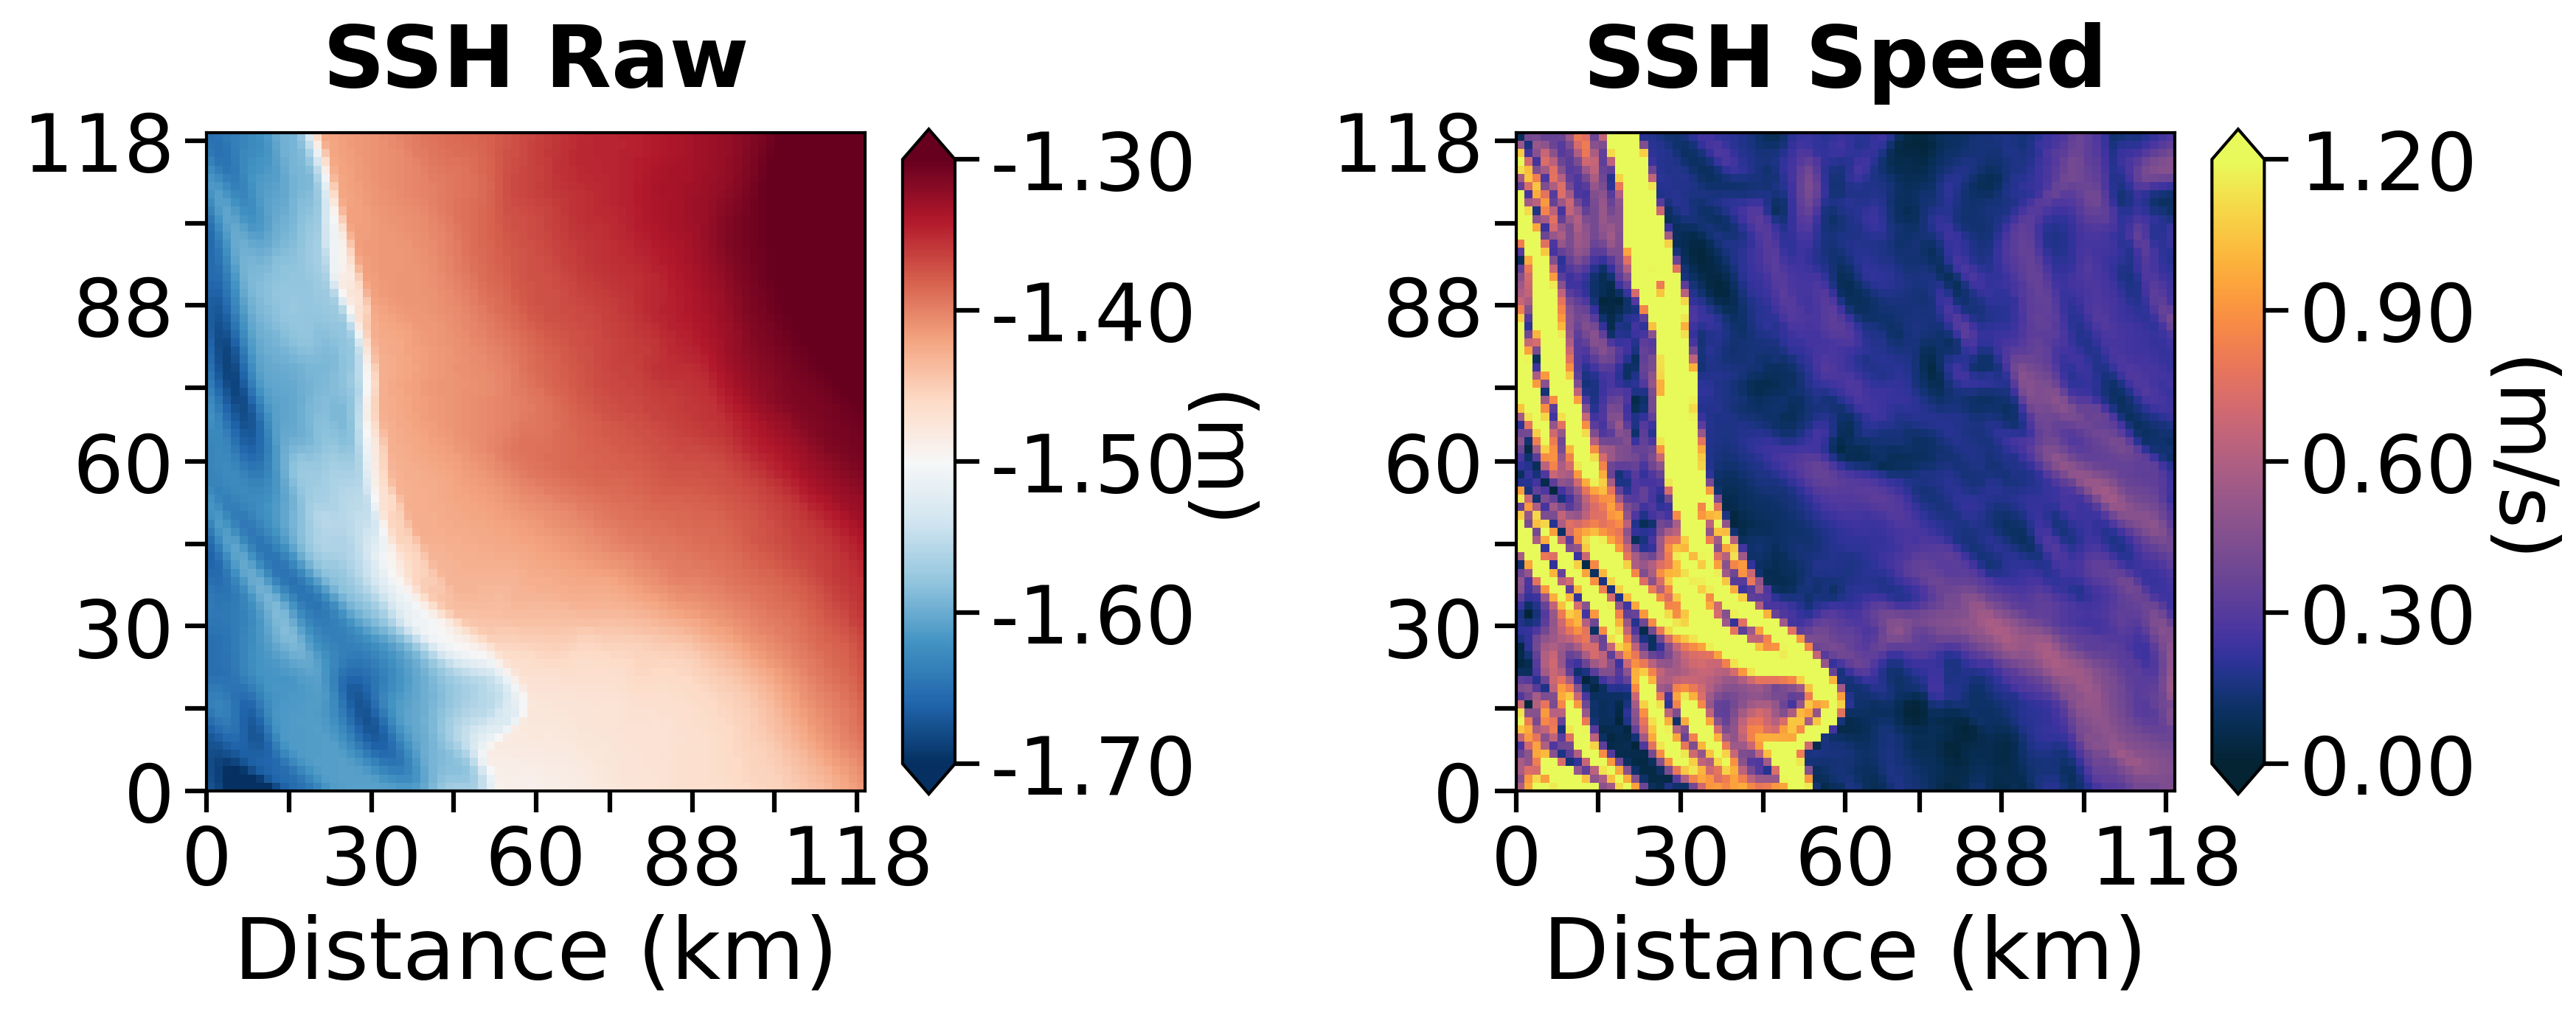

Worst SSH visualization saved (Sample #3323, R²=-6.2663)


In [3]:
# Function to create the 4x4 comparison plot
def create_comparison_plot(sample_idx, sample_type, r2_value, 
                          vmin_ubm=-0.04, vmax_ubm=0.04,
                          vmin_bm=-0.1, vmax_bm=0.1,
                          vmin_grad=0.0, vmax_grad=0.8):
    """Create 4x4 comparison plot for UBM, BM, and speeds"""
    
    # Extract data for the sample
    ssh_true = test.ssh.isel(sample=sample_idx).values
    ubm_true = test.ubm.isel(sample=sample_idx).values  
    bm_true = test.bm.isel(sample=sample_idx).values

    # Model predictions for the sample
    ubm_pred_sst_ssh = eval_datasets['sst_ssh'].ubm_pred_mean.isel(sample=sample_idx).values
    ubm_pred_ssh_only = eval_datasets['ssh_only'].ubm_pred_mean.isel(sample=sample_idx).values
    ubm_pred_mse_only = eval_datasets['mse_only'].ubm_pred_mean.isel(sample=sample_idx).values

    # Calculate BM from UBM predictions
    bm_pred_sst_ssh = ssh_true - ubm_pred_sst_ssh
    bm_pred_ssh_only = ssh_true - ubm_pred_ssh_only
    bm_pred_mse_only = ssh_true - ubm_pred_mse_only

    # Calculate geostrophic speeds
    ubm_true_speed = calculate_geostrophic_speed(ubm_true)
    ubm_pred_sst_ssh_speed = calculate_geostrophic_speed(ubm_pred_sst_ssh)
    ubm_pred_ssh_only_speed = calculate_geostrophic_speed(ubm_pred_ssh_only)
    ubm_pred_mse_only_speed = calculate_geostrophic_speed(ubm_pred_mse_only)

    bm_true_speed = calculate_geostrophic_speed(bm_true)
    bm_pred_sst_ssh_speed = calculate_geostrophic_speed(bm_pred_sst_ssh)
    bm_pred_ssh_only_speed = calculate_geostrophic_speed(bm_pred_ssh_only)
    bm_pred_mse_only_speed = calculate_geostrophic_speed(bm_pred_mse_only)

    # Create figure
    fig = plt.figure(figsize=(20, 20), dpi=300)
    gs = gridspec.GridSpec(4, 5, width_ratios=[1, 1, 1, 1, 0.05], 
                          height_ratios=[1, 1, 1, 1], wspace=0.01, hspace=0.1)

    col_titles = ['True', 'MSE+SST', 'ZCA', 'ZCA+SST']
    row_types = ['UBM', 'BM', 'UBM Speed', 'BM Speed']

    all_data = [
        [ubm_true, ubm_pred_mse_only, ubm_pred_ssh_only, ubm_pred_sst_ssh],
        [bm_true, bm_pred_mse_only, bm_pred_ssh_only, bm_pred_sst_ssh],
        [ubm_true_speed, ubm_pred_mse_only_speed, ubm_pred_ssh_only_speed, ubm_pred_sst_ssh_speed],
        [bm_true_speed, bm_pred_mse_only_speed, bm_pred_ssh_only_speed, bm_pred_sst_ssh_speed]
    ]

    all_cmaps = ['RdBu_r', 'RdBu_r', cmo.thermal, cmo.thermal]
    all_vmins = [vmin_ubm, vmin_bm, vmin_grad, vmin_grad]
    all_vmaxs = [vmax_ubm, vmax_bm, vmax_grad, vmax_grad]

    # Define colorbar ticks for each row based on the ranges
    def create_ticks(vmin, vmax, num_ticks=5):
        """Create evenly spaced ticks between vmin and vmax"""
        return np.linspace(vmin, vmax, num_ticks)

    all_ticks = [
        create_ticks(vmin_ubm, vmax_ubm, 5),  # UBM row
        create_ticks(vmin_bm, vmax_bm, 5),    # BM row
        create_ticks(vmin_grad, vmax_grad, 5), # UBM Speed row
        create_ticks(vmin_grad, vmax_grad, 5)  # BM Speed row
    ]

    # Plot all rows
    for row in range(4):
        for col, data in enumerate(all_data[row]):
            ax = fig.add_subplot(gs[row, col])
            im = ax.imshow(data, cmap=all_cmaps[row], vmin=all_vmins[row], vmax=all_vmaxs[row])
            
            col_title = col_titles[col] if row == 0 else None
            row_label = row_types[row] if col == 0 else None
            
            format_ax(ax, title=col_title, row_label=row_label)
            
            if col == 0:
                first_im = im
        
        # Add colorbar for each row
        cax = fig.add_subplot(gs[row, 4])
        cbar = plt.colorbar(first_im, cax=cax, extend='both')
        
        # Style colorbar
        pos = cax.get_position()
        new_pos = [pos.x0 * 1.0, pos.y0 + pos.height * -0.01, pos.width * 1.3, pos.height * 1.02]
        cax.set_position(new_pos)
        
        cbar.set_ticks(all_ticks[row])
        
        # Format colorbar ticks to 2 decimal places
        cbar.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))
        
        if row < 2:
            cbar.ax.set_ylabel('(m)', rotation=270, labelpad=30, fontsize=28)
        else:
            cbar.ax.set_ylabel('(m/s)', rotation=270, labelpad=40, fontsize=28)
        
        cbar.ax.tick_params(axis='y', length=8, width=1.5, labelsize=24)

    # Save figure
    plt.savefig(f'/home/jovyan/GRL_ssh/figures/{sample_type}_sample_comparison.png', 
                dpi=300, bbox_inches='tight', facecolor='white')
    # plt.savefig(f'/home/jovyan/GRL_ssh/figures/Figure_2/{sample_type}_sample_comparison.pdf', 
    #             dpi=300, bbox_inches='tight', facecolor='white')
    
    plt.show()
    print(f"{sample_type.capitalize()} sample comparison saved (Sample #{sample_idx}, R²={r2_value:.4f})")

def create_ssh_plot(sample_idx, sample_type, r2_value,
                   vmin_ssh=-0.04, vmax_ssh=0.04,
                   vmin_grad=0.0, vmax_grad=0.8):
    """Create 1x2 SSH plot"""
    
    # Extract SSH data
    ssh_sample = test.ssh.isel(sample=sample_idx).values
    ssh_grad_sample = calculate_geostrophic_speed(ssh_sample)

    # Create figure
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4.5), dpi=300)
    fig.subplots_adjust(wspace=0.75)  

    # Panel A: SSH Raw
    im1 = ax1.imshow(ssh_sample, cmap='RdBu_r', vmin=vmin_ssh, vmax=vmax_ssh, 
                     extent=[0, 80, 0, 80])
    format_ax_ssh(ax1, 'SSH Raw')

    # Colorbar for Panel A with custom ticks
    cbar1 = plt.colorbar(im1, ax=ax1, pad=0.05, aspect=12.7, fraction=0.07, extend='both')
    cbar1.set_label('(m)', rotation=270, fontsize=26, labelpad=18)
    
    # Set custom ticks for SSH colorbar
    ssh_ticks = np.linspace(vmin_ssh, vmax_ssh, 5)
    cbar1.set_ticks(ssh_ticks)
    
    cbar1.ax.tick_params(labelsize=26, length=8, width=1.5)
    cbar1.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    # Panel B: SSH Gradient Speed
    im2 = ax2.imshow(ssh_grad_sample, cmo.thermal, vmin=vmin_grad, vmax=vmax_grad, 
                     extent=[0, 80, 0, 80])
    format_ax_ssh(ax2, 'SSH Speed')

    # Colorbar for Panel B with custom ticks
    cbar2 = plt.colorbar(im2, ax=ax2, pad=0.05, aspect=12.7, fraction=0.07, extend='both')
    cbar2.set_label('(m/s)', rotation=270, fontsize=26, labelpad=25)
    
    # Set custom ticks for gradient speed colorbar
    grad_ticks = np.linspace(vmin_grad, vmax_grad, 5)
    cbar2.set_ticks(grad_ticks)
    
    cbar2.ax.tick_params(labelsize=26, length=8, width=1.5)
    cbar2.ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%.2f'))

    # Ensure equal aspect ratios
    ax1.set_aspect('equal')
    ax2.set_aspect('equal')

    # Save figure
    plt.savefig(f'/home/jovyan/GRL_ssh/figures/{sample_type}_ssh_comparison.png', 
               dpi=300, bbox_inches='tight', facecolor='white', edgecolor='none', format='png')
    # plt.savefig(f'/home/jovyan/GRL_ssh/figures/Figure_2/{sample_type}_ssh_comparison.pdf', 
    #            bbox_inches='tight', facecolor='white', edgecolor='none', format='pdf')
    
    plt.show()
    print(f"{sample_type.capitalize()} SSH visualization saved (Sample #{sample_idx}, R²={r2_value:.4f})")


    
plt.rcParams.update({
    'font.family': 'sans-serif',
    'font.sans-serif': ['Arial', 'DejaVu Sans', 'Helvetica', 'sans-serif'],
    'axes.linewidth': 1.0,
    'xtick.major.width': 1.0,
    'ytick.major.width': 1.0,
    'xtick.minor.width': 0.8,
    'ytick.minor.width': 0.8,
    'lines.linewidth': 1.5,
    'mathtext.fontset': 'stix',  
    'axes.grid': False,
    'figure.facecolor': 'white',
    'axes.facecolor': 'white'
})

title_fontsize = 32
title_pad = 15


sample_types = ['best', 'median', 'worst']
sample_keys = ['max', 'median', 'min']

# Define custom color ranges for each sample type
color_ranges = {
    'best': {
        'vmin_ubm': -0.04, 'vmax_ubm': 0.04,
        'vmin_bm': -0.08, 'vmax_bm': 0.00,
        'vmin_grad': 0.0, 'vmax_grad': 0.8,
        'vmin_ssh': -0.08, 'vmax_ssh': 0.00
    },
    'median': {
        'vmin_ubm': -0.01, 'vmax_ubm': 0.01,
        'vmin_bm': -1.2, 'vmax_bm': -1.1,
        'vmin_grad': 0.0, 'vmax_grad': 1.0,
        'vmin_ssh': -1.2, 'vmax_ssh': -1.1
    },
    'worst': {
        'vmin_ubm': -0.02, 'vmax_ubm': 0.02,
        'vmin_bm': -1.7, 'vmax_bm': -1.3,
        'vmin_grad': 0.0, 'vmax_grad': 1.2,
        'vmin_ssh': -1.7, 'vmax_ssh': -1.3
    }
}



for sample_type, sample_key in zip(sample_types, sample_keys):
    sample_idx = extreme_samples['sst_ssh'][sample_key]['sample_idx']
    r2_value = extreme_samples['sst_ssh'][sample_key]['r2']
    ranges = color_ranges[sample_type]
    
    
    # Create 4x4 comparison plot with custom ranges
    create_comparison_plot(sample_idx, sample_type, r2_value,
                          vmin_ubm=ranges['vmin_ubm'], vmax_ubm=ranges['vmax_ubm'],
                          vmin_bm=ranges['vmin_bm'], vmax_bm=ranges['vmax_bm'],
                          vmin_grad=ranges['vmin_grad'], vmax_grad=ranges['vmax_grad'])
    
    # Create 1x2 SSH plot with custom ranges
    create_ssh_plot(sample_idx, sample_type, r2_value,
                   vmin_ssh=ranges['vmin_ssh'], vmax_ssh=ranges['vmax_ssh'],
                   vmin_grad=ranges['vmin_grad'], vmax_grad=ranges['vmax_grad'])
